In [1]:
# 🧱 Step 1: Install & Import
!pip install -q ultralytics
from ultralytics import YOLO
import os, shutil, glob

# 🔧 Step 2: Set paths
base_path = "/kaggle/working/data"
os.makedirs(base_path, exist_ok=True)

# Copy dataset from input directory
!cp -r /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/* $base_path

# Rename to standard names (train/val/test folders)
os.rename(f"{base_path}/train", f"{base_path}/train")
os.rename(f"{base_path}/valid", f"{base_path}/val")
os.rename(f"{base_path}/test", f"{base_path}/test")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00:00:0100:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.c

In [2]:
# 🧹 Step 3: Clean & Remap Labels
def clean_and_remap_labels(label_dir, class_map):
    for file in glob.glob(f"{label_dir}/*.txt"):
        new_lines = []
        with open(file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id = int(parts[0])
                if class_id in class_map:
                    new_class_id = class_map[class_id]
                    new_lines.append(f"{new_class_id} " + " ".join(parts[1:]) + "\n")
        with open(file, "w") as f:
            f.writelines(new_lines)

class_map = {0: 0, 5: 1, 7: 2}  # Hardhat, Person, Safety Vest

# Clean train and val
clean_and_remap_labels(f"{base_path}/train/labels", class_map)
clean_and_remap_labels(f"{base_path}/val/labels", class_map)


In [3]:
# 🗑️ Step 4: Remove empty or invalid labels
def remove_unlabeled_images(img_dir, lbl_dir):
    for label_file in glob.glob(f"{lbl_dir}/*.txt"):
        if os.path.getsize(label_file) == 0:
            base = os.path.basename(label_file).replace(".txt", ".jpg")
            img_path = os.path.join(img_dir, base)
            if os.path.exists(img_path):
                os.remove(img_path)
            os.remove(label_file)

remove_unlabeled_images(f"{base_path}/train/images", f"{base_path}/train/labels")
remove_unlabeled_images(f"{base_path}/val/images", f"{base_path}/val/labels")


In [4]:
# 📝 Step 5: Write construction.yaml
yaml_content = """
path: /kaggle/working/data
train: train/images
val: val/images
test: test/images

names:
  0: Hardhat
  1: Person
  2: Safety Vest
"""

with open("construction.yaml", "w") as f:
    f.write(yaml_content)


In [5]:
# 🚀 Step 6: Train YOLOv8
model = YOLO("yolov8s.pt")

model.train(
    data="construction.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    name="ppe_detection_yolov8",
    project="runs"
)


100%|██████████| 21.5M/21.5M [00:00<00:00, 175MB/s]


Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=construction.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_detection_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1103.0±463.9 MB/s, size: 62.1 KB)


train: Scanning /kaggle/working/data/train/labels... 2530 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2530/2530 [00:01<00:00, 1383.38it/s]


train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 461.2±277.6 MB/s, size: 54.3 KB)


val: Scanning /kaggle/working/data/val/labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 1428.79it/s]

val: New cache created: /kaggle/working/data/val/labels.cache


Plotting labels to runs/ppe_detection_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/ppe_detection_yolov8
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.73G      1.349      1.817      1.427          9        640: 100%|██████████| 159/159 [00:42<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


                   all         84        286      0.446       0.45      0.401      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.54G      1.383       1.65       1.47          8        640: 100%|██████████| 159/159 [00:41<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


                   all         84        286      0.578      0.432       0.46       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.57G      1.399       1.63      1.485         11        640: 100%|██████████| 159/159 [00:42<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         84        286      0.594      0.427      0.465       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.61G      1.335      1.541      1.441          2        640: 100%|██████████| 159/159 [00:41<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

                   all         84        286      0.655      0.481      0.539      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.65G      1.288      1.417      1.404         12        640: 100%|██████████| 159/159 [00:42<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         84        286      0.769      0.521      0.618      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.67G      1.228      1.308      1.363          6        640: 100%|██████████| 159/159 [00:41<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


                   all         84        286       0.79      0.558      0.667      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.72G      1.162      1.184      1.321         11        640: 100%|██████████| 159/159 [00:41<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         84        286      0.776      0.638      0.701      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.76G      1.119      1.077      1.272         19        640: 100%|██████████| 159/159 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

                   all         84        286      0.905      0.597      0.738      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.79G      1.066     0.9802      1.241          6        640: 100%|██████████| 159/159 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         84        286      0.838      0.687      0.769      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.81G      1.021      0.913      1.208         14        640: 100%|██████████| 159/159 [00:42<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         84        286      0.906      0.683      0.788      0.461



10 epochs completed in 0.121 hours.
Optimizer stripped from runs/ppe_detection_yolov8/weights/last.pt, 22.5MB
Optimizer stripped from runs/ppe_detection_yolov8/weights/best.pt, 22.5MB

Validating runs/ppe_detection_yolov8/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         84        286      0.906      0.683      0.788      0.461
               Hardhat         42         79      0.961      0.709      0.828       0.51
                Person         84        166      0.876      0.657       0.76      0.423
           Safety Vest         28         41      0.882      0.683      0.776      0.451
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/ppe_detection_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e81682f4ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [12]:
results = model.predict(
    source=f"{base_path}/test/images", 
    conf=0.25,  # lower confidence threshold
    save=True
)


image 1/82 /kaggle/working/data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 1 Person, 16.3ms
image 2/82 /kaggle/working/data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 Persons, 16.2ms
image 3/82 /kaggle/working/data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 3 Persons, 16.2ms
image 4/82 /kaggle/working/data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 Person, 16.2ms
image 5/82 /kaggle/working/data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 6 Hardhats, 9 Persons, 1 Safety Vest, 16.2ms
image 6/82 /kaggle/working/data/test/images/004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 3 Hardhats, 4 Persons, 16.2ms
image 7/82 /kaggle/working/data/test/images/006463_jpg.rf.02f19082420ecc5537b9d59abbe6050c.jpg: 640x640 10 Hardhats, 12 Persons, 3 Safety Vests, 16.2ms
image 8/82 /kaggle/working/d

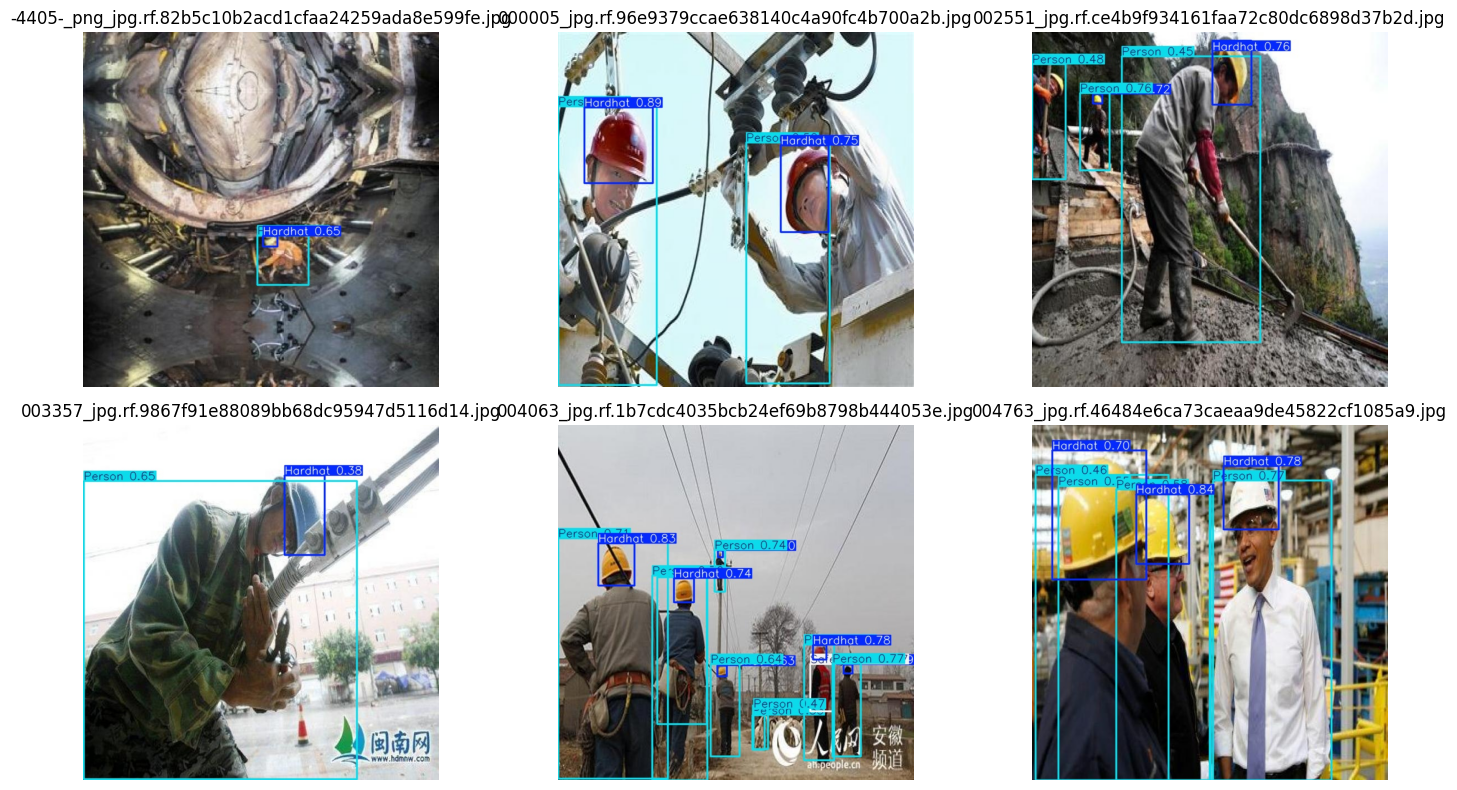

In [16]:
import glob, os
import matplotlib.pyplot as plt
import cv2

# ✅ Set your custom prediction folder path
latest_pred_dir = "/kaggle/working/runs/ppe_detection_yolov86"

# 🔍 Get all predicted images
pred_images = sorted(glob.glob(f"{latest_pred_dir}/*.jpg"))

# 🖼️ Show 6 predicted images
def show_images(image_paths, rows=2, cols=3):
    plt.figure(figsize=(15, 8))
    for i, img_path in enumerate(image_paths[:rows * cols]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Run display
if pred_images:
    show_images(pred_images)
else:
    print("❌ No prediction images found in:", latest_pred_dir)

In [17]:
metrics = model.val()  # After training is done
print(metrics.box)     # Box precision, recall, mAP50, mAP50-95

Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1412.2±410.2 MB/s, size: 60.5 KB)


val: Scanning /kaggle/working/data/val/labels.cache... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         84        286      0.905      0.683      0.789      0.461
               Hardhat         42         79      0.958      0.709      0.829      0.509
                Person         84        166      0.876      0.657      0.762      0.425
           Safety Vest         28         41      0.881      0.683      0.777       0.45
Speed: 3.6ms preprocess, 11.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/ppe_detection_yolov87
ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[    0.82851,     0.82851,     0.82724,      0.7789,     0.72903,     0.62107,     0.31773,     0.13178,    0.023655,           0],
       [    0.76172,      0.7562,     0.72275,     0.64418,     0.53724,     0.37739,     0.28363,     0.14688,     0.01768,           0],
       [    0.77692,     0.75726,     0.74761,     0.66773,     0.62945,     0.52649,     0.23933,     0.11989,     0.03358,           0]])
ap: array([    0.50864,     0.424

In [18]:
# export model 
model.export(format="onnx")

Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/ppe_detection_yolov8/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 3.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 6.2s, saved as 'runs/ppe_detection_yolov8/weights/best.onnx' (42.7 MB)

Export complete (6.8s)
Results saved to /kaggle/working/runs/ppe_detection_yolov8/weights
Predict:         yolo predict task=detect model=runs/ppe_detection_yolov8/weights/best.onnx imgsz=640  
Validate: 

'runs/ppe_detection_yolov8/weights/best.onnx'

In [19]:
results = model.predict(source="/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg", conf=0.3)
results[0].save(filename="output.jpg")


image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 2 Hardhats, 2 Persons, 17.3ms
Speed: 2.1ms preprocess, 17.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


'output.jpg'

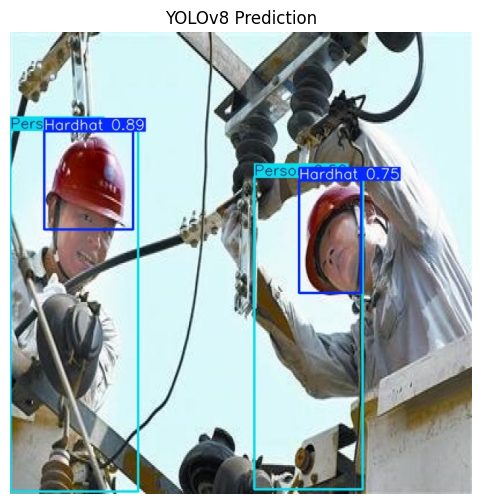

In [20]:
import cv2
import matplotlib.pyplot as plt

# Load the saved image
img = cv2.imread("output.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("YOLOv8 Prediction")
plt.axis("off")
plt.show()

# Load the exported model 

In [21]:
from ultralytics import YOLO

# Load ONNX model
model = YOLO("/kaggle/working/runs/ppe_detection_yolov8/weights/best.onnx")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [22]:
# Run prediction on a test image
results = model("/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg", conf=0.3)

Loading /kaggle/working/runs/ppe_detection_yolov8/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 Hardhats, 9 Persons, 1 Safety Vest, 20.8ms
Speed: 3.3ms preprocess, 20.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


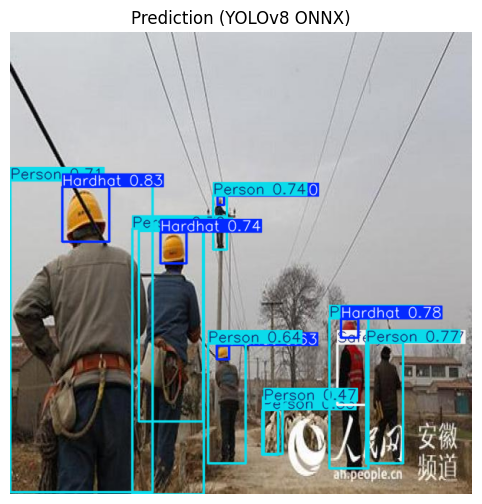

In [23]:
# Show the image with boxes
results[0].plot()  # returns an annotated image (numpy array)
img = results[0].plot()

# Display using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Prediction (YOLOv8 ONNX)")
plt.axis("off")
plt.show()